In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error


In [12]:


endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=2000&toTs=1589810447')
hist = pd.DataFrame(json.loads(res.content)['Data'])
print(hist)

            time      high       low      open  volumefrom    volumeto  \
0     1416960000    634.42    321.20    489.13       39.12    17689.88   
1     1417046400    624.93    378.88    479.00       40.47    17505.80   
2     1417132800    479.27    395.38    454.89       50.27    21813.36   
3     1417219200    652.74    399.92    467.73       77.35    35020.43   
4     1417305600    644.12    391.65    479.09       26.16    11022.21   
...          ...       ...       ...       ...         ...         ...   
1996  1589414400  13897.76  13124.03  13143.68      674.17  9129434.08   
1997  1589500800  13824.97  12956.11  13758.73      516.07  6921489.61   
1998  1589587200  13608.66  13051.31  13139.80      330.00  4385643.37   
1999  1589673600  13909.87  13206.29  13285.72      311.85  4244329.45   
2000  1589760000  14001.81  13405.12  13660.17      340.14  4635265.87   

         close conversionType conversionSymbol  
0       321.20         direct                   
1       454.8

In [13]:
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [14]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [15]:
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2014-11-26,634.42,321.20,489.13,39.12,17689.88,321.20
2014-11-27,624.93,378.88,479.00,40.47,17505.80,454.89
2014-11-28,479.27,395.38,454.89,50.27,21813.36,467.73
2014-11-29,652.74,399.92,467.73,77.35,35020.43,479.09
2014-11-30,644.12,391.65,479.09,26.16,11022.21,391.65
...,...,...,...,...,...,...
2020-05-14,13897.76,13124.03,13143.68,674.17,9129434.08,13758.73
2020-05-15,13824.97,12956.11,13758.73,516.07,6921489.61,13139.80
2020-05-16,13608.66,13051.31,13139.80,330.00,4385643.37,13285.72


In [13]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [14]:
train, test = train_test_split(hist, test_size=0.2)

In [15]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

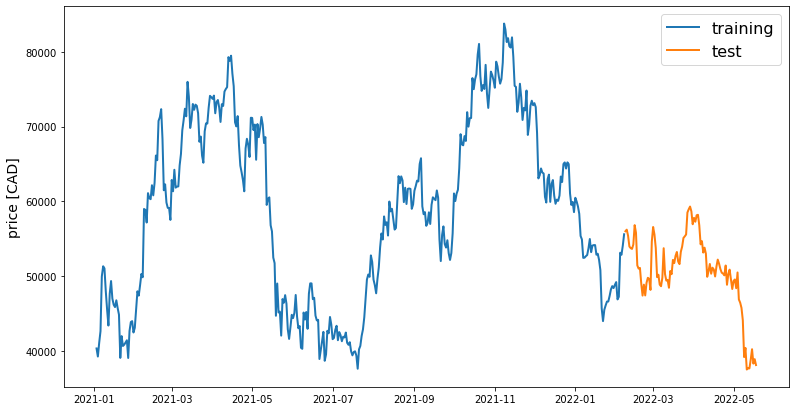

In [16]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [17]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [18]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [19]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [20]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [21]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [22]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [23]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 30ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 2/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 3/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0028
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 8/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 9/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 10/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 11/20
13/1

In [24]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 0s 3ms/step


0.02952871382247299

In [25]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6859555609037309

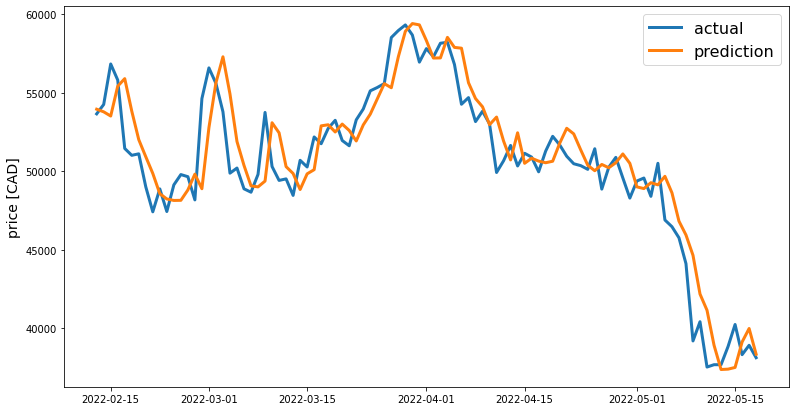

In [26]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [27]:
prediction = np.array([39192.21,38030.26,38924.29,19.88,762212.41,38189.03])

In [28]:
import pickle

In [30]:
print('...Exporting the model...')
model.save("asi_model.h5")

...Exporting the model...
